## Google Colab Notebook for Car Retrieval System

Objective: Detect cars using SSD MobileNet and classify their types (e.g., MPV, Sedan, Hatchback) using ResNet50.



# Setup and Initializations

In [92]:
import os
import zipfile
import cv2
import numpy as np
import json
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Reshape, MaxPooling2D, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU, CategoricalAccuracy, SparseCategoricalAccuracy
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [57]:
print(f"TensorFlow version: {tf.__version__}")
if hub:
    print(f"TensorFlow Hub version: {hub.__version__}")
else:
    print("TensorFlow Hub not imported or available.")

gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU available: {gpu_devices}")

TensorFlow version: 2.18.0
TensorFlow Hub version: 0.16.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configuration

Source dataset:
- https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset
- https://www.kaggle.com/datasets/gunawan26/labelled-indonesian-car-and-plate-number

In [59]:
indonesian_car_zip_path = "/content/drive/My Drive/ImageClassificationObjectDetectionTask/datasets/LabelledIndonesianCarandPlateNumber.zip"
stanford_car_zip_path = "/content/drive/My Drive/ImageClassificationObjectDetectionTask/datasets/StanfordCarsDataset.zip"

In [60]:
indonesian_car_extract_dir = "/content/indonesian_car_dataset/"
stanford_car_extract_dir = "/content/stanford_car_dataset/"

In [61]:
os.makedirs(indonesian_car_extract_dir, exist_ok=True)
os.makedirs(stanford_car_extract_dir, exist_ok=True)

In [62]:
print(f"Unzipping {indonesian_car_zip_path} to {indonesian_car_extract_dir}...")
try:
    with zipfile.ZipFile(indonesian_car_zip_path, 'r') as zip_ref:
        zip_ref.extractall(indonesian_car_extract_dir)
    print("Indonesian Car Dataset unzipped successfully.")
except FileNotFoundError:
    print(f"Error: {indonesian_car_zip_path} not found. Please check the path.")
except Exception as e:
    print(f"Error unzipping Indonesian Car Dataset: {e}")

Unzipping /content/drive/My Drive/ImageClassificationObjectDetectionTask/datasets/LabelledIndonesianCarandPlateNumber.zip to /content/indonesian_car_dataset/...
Indonesian Car Dataset unzipped successfully.


In [63]:
try:
    with zipfile.ZipFile(stanford_car_zip_path, 'r') as zip_ref:
        zip_ref.extractall(stanford_car_extract_dir)
    print("Stanford Cars Dataset unzipped successfully.")
except FileNotFoundError:
    print(f"Error: {stanford_car_zip_path} not found. Please check the path.")
except Exception as e:
    print(f"Error unzipping Stanford Cars Dataset: {e}")

Stanford Cars Dataset unzipped successfully.


In [64]:
print("Contents of Stanford Cars Dataset:")
!ls "{stanford_car_extract_dir}"
!ls "{stanford_car_extract_dir}/car_devkit"
!ls "{stanford_car_extract_dir}/cars_train"
!ls "{stanford_car_extract_dir}/cars_test"

Contents of Stanford Cars Dataset:
car_devkit  cars_test  cars_train
devkit
cars_train
cars_test


In [65]:
mobilcoco_base_path = os.path.join(indonesian_car_extract_dir, 'MobilCoco')
print(f"Contents of MobilCoco directory: {mobilcoco_base_path}")
!ls "{mobilcoco_base_path}"
!ls "{mobilcoco_base_path}/JPEGImages"

Contents of MobilCoco directory: /content/indonesian_car_dataset/MobilCoco
annotations.json  JPEGImages
 agya10.jpg	 brio24.jpg	  fortuner39.jpg   jazz1.jpg	 swift33.jpg
 agya11.jpg	 brio25.jpg	  fortuner3.jpg    jazz20.jpg	 swift34.jpg
 agya12.jpg	 brio26.jpg	  fortuner40.jpg   jazz21.jpg	 swift35.jpg
 agya13.jpg	 brio27.jpg	  fortuner4.jpg    jazz22.jpg	 swift36.jpg
 agya14.jpg	 brio28.jpg	  fortuner5.jpg    jazz23.jpg	 swift37.jpg
 agya15.jpg	 brio29.jpg	  fortuner6.jpg    jazz24.jpg	 swift38.jpg
 agya16.jpg	 brio2.jpg	  fortuner7.jpg    jazz25.jpg	 swift39.jpg
 agya17.jpg	 brio30.jpg	  fortuner8.jpg    jazz26.jpg	 swift3.jpg
 agya18.jpg	 brio31.jpg	  fortuner9.jpg    jazz27.jpg	 swift40.jpg
 agya19.jpg	 brio32.jpg	  hitam_01.jpg	   jazz28.jpg	 swift4.jpg
 agya1.jpg	 brio33.jpg	  hitam_02.jpg	   jazz29.jpg	 swift5.jpg
 agya20.jpg	 brio34.jpg	  hitam_03.jpg	   jazz2.jpg	 swift6.jpg
 agya21.jpg	 brio35.jpg	  hitam_04.jpg	   jazz30.jpg	 swift7.jpg
 agya22.jpg	 brio36.jpg	  hitam_05.jpg

In [66]:
IMG_WIDTH_DETECTION = 300
IMG_HEIGHT_DETECTION = 300
IMG_WIDTH_CLASSIFICATION = 224
IMG_HEIGHT_CLASSIFICATION = 224
BATCH_SIZE = 16
EPOCHS_DETECTION = 25
EPOCHS_CLASSIFICATION = 25
LEARNING_RATE_DETECTION = 1e-4
LEARNING_RATE_CLASSIFICATION = 1e-4

In [67]:
import scipy.io
import os
import numpy as np

stanford_car_extract_dir = "/content/stanford_car_dataset/"
cars_meta_path = os.path.join(stanford_car_extract_dir, 'car_devkit', 'devkit', 'cars_meta.mat')

print(f"Attempting to read file: {cars_meta_path}")

try:
    meta_data = scipy.io.loadmat(cars_meta_path)

    print("\n--- Contents of cars_meta.mat ---")

    if 'class_names' in meta_data:
        unique_car_labels = [name[0] for name in meta_data['class_names'][0]]

        print("\nUnique Car Labels (Classes) from Stanford Cars Dataset:")
        for i, label in enumerate(unique_car_labels):
            print(f"  {i+1}: {label}")
        print(f"\nTotal unique car types found: {len(unique_car_labels)}")
    else:
        print("\n'class_names' key not found in cars_meta.mat. The file structure might be different.")

    print("\n--- Full dictionary contents (for debugging) ---")
    for key, value in meta_data.items():
        print(f"\nKey: {key}")
        print(f"  Type: {type(value)}")
        if hasattr(value, 'shape'):
            print(f"  Shape: {value.shape}")
        if isinstance(value, np.ndarray) and value.size > 0:
            print(f"  First few values: {value.flatten()[:5]}")
        elif isinstance(value, list) and len(value) > 0:
            print(f"  First few values: {value[:5]}")

    print("\n--- Reading Complete ---")

except FileNotFoundError:
    print(f"\nERROR: File {cars_meta_path} not found.")
except Exception as e:
    print(f"\nAn error occurred while reading the .mat file: {e}")

Attempting to read file: /content/stanford_car_dataset/car_devkit/devkit/cars_meta.mat

--- Contents of cars_meta.mat ---

Unique Car Labels (Classes) from Stanford Cars Dataset:
  1: AM General Hummer SUV 2000
  2: Acura RL Sedan 2012
  3: Acura TL Sedan 2012
  4: Acura TL Type-S 2008
  5: Acura TSX Sedan 2012
  6: Acura Integra Type R 2001
  7: Acura ZDX Hatchback 2012
  8: Aston Martin V8 Vantage Convertible 2012
  9: Aston Martin V8 Vantage Coupe 2012
  10: Aston Martin Virage Convertible 2012
  11: Aston Martin Virage Coupe 2012
  12: Audi RS 4 Convertible 2008
  13: Audi A5 Coupe 2012
  14: Audi TTS Coupe 2012
  15: Audi R8 Coupe 2012
  16: Audi V8 Sedan 1994
  17: Audi 100 Sedan 1994
  18: Audi 100 Wagon 1994
  19: Audi TT Hatchback 2011
  20: Audi S6 Sedan 2011
  21: Audi S5 Convertible 2012
  22: Audi S5 Coupe 2012
  23: Audi S4 Sedan 2012
  24: Audi S4 Sedan 2007
  25: Audi TT RS Coupe 2012
  26: BMW ActiveHybrid 5 Sedan 2012
  27: BMW 1 Series Convertible 2012
  28: BMW 1 Se

In [68]:
import os
import json

indonesian_car_extract_dir = "/content/indonesian_car_dataset/"
mobilcoco_base_path = os.path.join(indonesian_car_extract_dir, 'MobilCoco')
annotations_json_path = os.path.join(mobilcoco_base_path, 'annotations.json')

print(f"Attempting to read annotations.json file from: {annotations_json_path}")

try:
    if not os.path.exists(annotations_json_path):
        raise FileNotFoundError(f"File not found at: {annotations_json_path}")

    with open(annotations_json_path, 'r') as f:
        coco_data = json.load(f)

    print("\n--- Contents of annotations.json (Brief Structure) ---")

    print(f"Main keys in JSON: {list(coco_data.keys())}")

    if 'categories' in coco_data:
        categories = coco_data['categories']
        print(f"\nNumber of categories found: {len(categories)}")
        print("List of Categories (Car Types):")

        for cat in categories:
            print(f"  ID: {cat.get('id')}, Name: {cat.get('name')}")
            if 'supercategory' in cat:
                print(f"    Supercategory: {cat['supercategory']}")
    else:
        print("\nKey 'categories' not found in annotations.json.")

    if 'annotations' in coco_data:
        annotations = coco_data['annotations']
        print(f"\nNumber of annotations found: {len(annotations)}")
        print("\nExample of the First 5 Annotations:")
        for i, ann in enumerate(annotations[:5]):
            print(f"  Annotation {i+1}:")
            print(f"    image_id: {ann.get('image_id')}")
            print(f"    category_id: {ann.get('category_id')}")
            print(f"    bbox: {ann.get('bbox')}")
            print(f"    area: {ann.get('area')}")
            print("  ---")
    else:
        print("\nKey 'annotations' not found in annotations.json.")

    if 'images' in coco_data:
        images = coco_data['images']
        print(f"\nNumber of referenced images: {len(images)}")
        print("\nExample of the First 5 Image Details:")
        for i, img in enumerate(images[:5]):
            print(f"  Image {i+1}:")
            print(f"    id: {img.get('id')}")
            print(f"    file_name: {img.get('file_name')}")
            print(f"    width: {img.get('width')}, height: {img.get('height')}")
            print("  ---")
    else:
        print("\nKey 'images' not found in annotations.json.")

    print("\n--- annotations.json check complete ---")

except FileNotFoundError as e:
    print(f"\nERROR: {e}")
    print("Ensure the file 'LabelledIndonesianCarandPlateNumber.zip' has been unzipped correctly.")
    print("And that the 'indonesian_car_extract_dir' path is adjusted to the correct location.")
except json.JSONDecodeError as e:
    print(f"\nERROR: Failed to decode JSON. Ensure the file '{annotations_json_path}' is a valid JSON.")
    print(f"Error details: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Attempting to read annotations.json file from: /content/indonesian_car_dataset/MobilCoco/annotations.json

--- Contents of annotations.json (Brief Structure) ---
Main keys in JSON: ['info', 'licenses', 'images', 'type', 'annotations', 'categories']

Number of categories found: 12
List of Categories (Car Types):
  ID: 0, Name: _background_
    Supercategory: None
  ID: 1, Name: All_New_Daihatsu_Terios
    Supercategory: None
  ID: 2, Name: Toyota_Agya
    Supercategory: None
  ID: 3, Name: Toyota_Avanza
    Supercategory: None
  ID: 4, Name: Toyota_Fortuner
    Supercategory: None
  ID: 5, Name: Honda_Brio
    Supercategory: None
  ID: 6, Name: Honda_CRV
    Supercategory: None
  ID: 7, Name: Honda_Jazz
    Supercategory: None
  ID: 8, Name: Honda_HRV
    Supercategory: None
  ID: 9, Name: Mitsubishi_Xpander
    Supercategory: None
  ID: 10, Name: Suzuki_Swift
    Supercategory: None
  ID: 11, Name: plat
    Supercategory: None

Number of annotations found: 557

Example of the First 5 A

In [69]:
mobilcoco_images_path = os.path.join(mobilcoco_base_path, 'JPEGImages')

In [70]:
TARGET_CAR_TYPES = [
    "Hatchback",
    "MPV",
    "SUV",
    "Sedan",
    "Coupe",
    "Convertible",
    "Wagon",
    "Truck",
    "Van",
    "Other"
]
NUM_TARGET_CAR_TYPES = len(TARGET_CAR_TYPES)

In [71]:
label_encoder = LabelEncoder()
label_encoder.fit(TARGET_CAR_TYPES)

LabelEncoder()

In [72]:
def map_stanford_label_to_general_type(stanford_label):
    label_lower = stanford_label.lower()
    if "hatchback" in label_lower:
        return "Hatchback"
    elif "mpv" in label_lower or "minivan" in label_lower:
        return "MPV"
    elif "suv" in label_lower:
        return "SUV"
    elif "sedan" in label_lower:
        return "Sedan"
    elif "coupe" in label_lower:
        return "Coupe"
    elif "convertible" in label_lower:
        return "Convertible"
    elif "wagon" in label_lower:
        return "Wagon"
    elif "truck" in label_lower or "pickup" in label_lower:
        return "Truck"
    elif "van" in label_lower:
        return "Van"
    else:
        return "Other"

In [73]:
mobilcoco_model_to_general_type_mapping = {
    "Toyota_Agya": "Hatchback",
    "Honda_Brio": "Hatchback",
    "Honda_Jazz": "Hatchback",
    "Suzuki_Swift": "Hatchback",

    "Toyota_Avanza": "MPV",
    "Mitsubishi_Xpander": "MPV",

    "All_New_Daihatsu_Terios": "SUV",
    "Toyota_Fortuner": "SUV",
    "Honda_CRV": "SUV",
    "Honda_HRV": "SUV",

    "_background_": "Other",
    "plat": "Other",
}

In [74]:
def parse_stanford_cars_for_detection(annos_mat_path: str, images_dir: str):
    print(f"\n--- Parsing Stanford Cars Dataset for Detection ---")
    print(f"Annotation file: {annos_mat_path}")
    print(f"Images directory: {images_dir}")

    if not os.path.exists(annos_mat_path):
        print(f"ERROR: Stanford annotations file NOT FOUND at {annos_mat_path}")
        return []
    if not os.path.isdir(images_dir):
        print(f"ERROR: Stanford images directory NOT FOUND at {images_dir}")
        return []

    try:
        mat_contents = scipy.io.loadmat(annos_mat_path)
        annotations = mat_contents['annotations'][0]
    except Exception as e:
        print(f"ERROR: Could not load or parse .mat file {annos_mat_path}. Error: {e}")
        return []

    img_to_annotations = {}
    processed_annotation_count = 0
    skipped_image_path_count = 0
    skipped_bbox_invalid_count = 0
    total_mat_annotations = len(annotations)

    print(f"Total annotations in .mat file: {total_mat_annotations}")

    for ann_item_struct in tqdm(annotations, desc="Parsing Stanford detection annotations"):
        try:
            if not (hasattr(ann_item_struct, 'dtype') and
                    all(field in ann_item_struct.dtype.names for field in ['fname', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'])):
                print(f"DEBUG: Skipping annotation due to unexpected structure: {ann_item_struct}")
                continue

            relative_image_filename = ann_item_struct['fname'][0]
            image_path_constructed = os.path.join(images_dir, relative_image_filename)
            image_path_constructed = os.path.normpath(image_path_constructed)

            if not os.path.exists(image_path_constructed):
                skipped_image_path_count += 1
                continue

            img = cv2.imread(image_path_constructed)
            if img is None:
                print(f"DEBUG: Failed to load image: {image_path_constructed}")
                skipped_image_path_count +=1
                continue

            img_h, img_w = img.shape[:2]

            if img_w <= 0 or img_h <= 0:
                print(f"DEBUG: Invalid image dimensions for {relative_image_filename}: w={img_w}, h={img_h}")
                continue

            x_min_px = float(ann_item_struct['bbox_x1'][0][0])
            y_min_px = float(ann_item_struct['bbox_y1'][0][0])
            x_max_px = float(ann_item_struct['bbox_x2'][0][0])
            y_max_px = float(ann_item_struct['bbox_y2'][0][0])

            norm_x_min = np.clip(x_min_px / img_w, 0., 1.)
            norm_y_min = np.clip(y_min_px / img_h, 0., 1.)
            norm_x_max = np.clip(x_max_px / img_w, 0., 1.)
            norm_y_max = np.clip(y_max_px / img_h, 0., 1.)

            if norm_x_max <= norm_x_min or norm_y_max <= norm_y_min:
                skipped_bbox_invalid_count += 1
                continue

            class_label_for_detection = 0

            if image_path_constructed not in img_to_annotations:
                img_to_annotations[image_path_constructed] = {'boxes': [], 'labels': []}

            img_to_annotations[image_path_constructed]['boxes'].append([norm_y_min, norm_x_min, norm_y_max, norm_x_max])
            img_to_annotations[image_path_constructed]['labels'].append(class_label_for_detection)
            processed_annotation_count += 1

        except Exception as e:
            filename_for_error = "Unknown"
            if hasattr(ann_item_struct, 'dtype') and 'fname' in ann_item_struct.dtype.names:
                filename_for_error = ann_item_struct['fname'][0]
            print(f"DEBUG: Error processing an annotation item (filename: {filename_for_error}). Error: {e}")
            continue

    processed_data = [{'image_path': k,
                       'boxes': np.array(v['boxes'], dtype=np.float32),
                       'labels': np.array(v['labels'], dtype=np.int32)}
                      for k, v in img_to_annotations.items() if v['boxes']]

    print(f"\n--- DEBUG Summary for Stanford Cars Detection Parsing ---")
    print(f"Total unique images with valid annotations processed: {len(processed_data)}")
    print(f"Total annotations successfully processed: {processed_annotation_count}")
    print(f"Annotations skipped due to image file not found or unreadable: {skipped_image_path_count}")
    print(f"Annotations skipped due to invalid bounding box coordinates: {skipped_bbox_invalid_count}")
    print(f"Total annotations in .mat file: {total_mat_annotations}")

    return processed_data

In [75]:
def parse_coco_annotations_for_classification(annotations_path, images_dir, model_to_type_map, target_types_list, label_enc):
    print(f"DEBUG PARSING CLS: Starting parse_coco_annotations_for_classification.")
    print(f"DEBUG PARSING CLS: Target Types List: {target_types_list}")
    if not os.path.exists(annotations_path):
        print(f"ERROR PARSING CLS: Annotations file NOT FOUND at {annotations_path}")
        return []
    if not os.path.isdir(images_dir):
        print(f"ERROR PARSING CLS: Images directory NOT FOUND at {images_dir}")
        return []

    with open(annotations_path, 'r') as f:
        coco_data = json.load(f)

    images_info = {img['id']: {'file_name': img['file_name'], 'height': img['height'], 'width': img['width']}
                   for img in coco_data.get('images', [])}
    coco_categories_map = {cat['id']: cat['name'] for cat in coco_data.get('categories', [])}

    classification_samples = []
    skipped_unmapped = 0
    skipped_other_or_irrelevant = 0
    processed_count = 0

    annotations_list = coco_data.get('annotations', [])
    print(f"DEBUG PARSING CLS: Total number of annotations: {len(annotations_list)}")

    for i, ann_item in enumerate(tqdm(annotations_list, desc="Parsing classification annotations")):
        processed_count += 1
        image_id = ann_item['image_id']
        category_id = ann_item['category_id']
        specific_model_name = coco_categories_map.get(category_id)

        if i < 20 or i > len(annotations_list) - 20:
            print(f"\nDEBUG PARSING CLS (Item {i}): Annotation: {ann_item}")
            print(f"DEBUG PARSING CLS (Item {i}): category_id={category_id}, specific_model_name='{specific_model_name}'")

        if not specific_model_name:
            print(f"DEBUG PARSING CLS (Item {i}): specific_model_name not found for category_id={category_id}. Continuing.")
            continue

        general_car_type = model_to_type_map.get(specific_model_name)
        if i < 20 or i > len(annotations_list) - 20:
             print(f"DEBUG PARSING CLS (Item {i}): specific_model_name='{specific_model_name}' -> general_car_type='{general_car_type}'")


        if not general_car_type:
            print(f"DEBUG PARSING CLS (Item {i}): Model '{specific_model_name}' not in mapping. Skipping.")
            skipped_unmapped += 1
            continue

        is_other = general_car_type == "Other"
        is_not_in_target = general_car_type not in target_types_list
        if i < 20 or i > len(annotations_list) - 20:
            print(f"DEBUG PARSING CLS (Item {i}): general_car_type='{general_car_type}', is_other={is_other}, is_not_in_target={is_not_in_target}")


        if is_other or is_not_in_target:
            if i < 20 or i > len(annotations_list) - 20:
                if is_other:
                    print(f"DEBUG PARSING CLS (Item {i}): Skipping '{specific_model_name}' because general_car_type is 'Other'.")
                if is_not_in_target and not is_other :
                     print(f"DEBUG PARSING CLS (Item {i}): Skipping '{specific_model_name}' (general_type='{general_car_type}') because it's not in target_types_list: {target_types_list}")
            skipped_other_or_irrelevant += 1
            continue

        img_meta = images_info.get(image_id)
        if not img_meta:
            print(f"DEBUG PARSING CLS (Item {i}): img_meta not found for image_id={image_id}. Continuing.")
            continue

        original_filename_from_json = img_meta['file_name']
        actual_image_filename = original_filename_from_json
        if actual_image_filename.startswith("JPEGImages//"):
            actual_image_filename = actual_image_filename[len("JPEGImages//"):]
        elif actual_image_filename.startswith("JPEGImages/"):
            actual_image_filename = actual_image_filename[len("JPEGImages/"):]
        image_path_constructed = os.path.normpath(os.path.join(images_dir, actual_image_filename))

        if not os.path.exists(image_path_constructed):
            print(f"DEBUG PARSING CLS (Item {i}): Image file not found: {image_path_constructed}. Continuing.")
            continue

        bbox_pixels = ann_item['bbox']

        try:
            encoded_label = label_enc.transform([general_car_type])[0]
        except ValueError:
            print(f"DEBUG PARSING CLS (Item {i}): Error encoding label: {general_car_type}. Ensure it's in TARGET_CAR_TYPES and label_encoder is fitted.")
            continue

        if i < 20 or i > len(annotations_list) - 20:
           print(f"DEBUG PARSING CLS (Item {i}): ADDING DATA: img='{actual_image_filename}', type='{general_car_type}', label={encoded_label}")

        classification_samples.append({
            'image_path': image_path_constructed,
            'bbox_pixels': np.array(bbox_pixels, dtype=np.float32),
            'class_label': encoded_label,
            'class_name': general_car_type,
            'original_width': img_meta['width'],
            'original_height': img_meta['height']
        })

    print(f"DEBUG PARSING CLS: Loop finished. Total annotations processed: {processed_count}")
    print(f"DEBUG PARSING CLS: Skipped (unmapped): {skipped_unmapped}")
    print(f"DEBUG PARSING CLS: Skipped (Other or not in target): {skipped_other_or_irrelevant}")
    print(f"DEBUG PARSING CLS: Total classification_samples collected: {len(classification_samples)}")
    if not classification_samples and (skipped_unmapped > 0 or skipped_other_or_irrelevant > 0):
        print("DEBUG PARSING CLS: NO CLASSIFICATION DATA GENERATED BECAUSE ALL WERE SKIPPED.")
        if skipped_unmapped == processed_count and processed_count > 0:
            print("   -> It seems all 'specific_model_name' from JSON are not in 'mobilcoco_model_to_general_type_mapping'. Check name matching!")
        elif skipped_other_or_irrelevant == processed_count and processed_count > 0:
             print("   -> It seems all mapped models are 'Other' or not included in 'TARGET_CAR_TYPES'. Check mapping and TARGET_CAR_TYPES!")


    return classification_samples

In [76]:
def load_and_preprocess_image_detection(image_path, target_height, target_width):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [target_height, target_width])
    image = image / 255.0
    return image

def load_detection_data(data_entry):
    image = load_and_preprocess_image_detection(data_entry['image_path'], IMG_HEIGHT_DETECTION, IMG_WIDTH_DETECTION)
    boxes = tf.cast(data_entry['boxes'], dtype=tf.float32)
    labels = tf.cast(data_entry['labels'], dtype=tf.int32)
    return image, (boxes, labels)

def load_and_preprocess_image_classification(image_path, bbox_pixels, original_w, original_h, target_height, target_width):
    image_content = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_content, channels=3)

    x_min, y_min, w, h = bbox_pixels[0], bbox_pixels[1], bbox_pixels[2], bbox_pixels[3]

    y_min_abs = tf.maximum(0, tf.cast(y_min, tf.int32))
    x_min_abs = tf.maximum(0, tf.cast(x_min, tf.int32))
    y_max_abs = tf.minimum(tf.cast(original_h, tf.int32), tf.cast(y_min + h, tf.int32))
    x_max_abs = tf.minimum(tf.cast(original_w, tf.int32), tf.cast(x_min + w, tf.int32))

    crop_h = tf.maximum(1, y_max_abs - y_min_abs)
    crop_w = tf.maximum(1, x_max_abs - x_min_abs)

    cropped_image = tf.image.crop_to_bounding_box(image, y_min_abs, x_min_abs, crop_h, crop_w)

    cropped_image_resized = tf.image.resize(cropped_image, [target_height, target_width])
    cropped_image_resized = cropped_image_resized / 255.0
    return cropped_image_resized

def load_classification_data(data_entry):
    bbox_tensor = tf.convert_to_tensor(data_entry['bbox_pixels'], dtype=tf.float32)
    image = load_and_preprocess_image_classification(
        data_entry['image_path'],
        bbox_tensor,
        data_entry['original_width'],
        data_entry['original_height'],
        IMG_HEIGHT_CLASSIFICATION,
        IMG_WIDTH_CLASSIFICATION
    )
    label = tf.constant(label_encoder.transform([data_entry['class_name']])[0], dtype=tf.int32)
    return image, label

In [77]:
print("\n--- Pre-Parsing Sanity Checks ---")
if not os.path.exists(annotations_json_path):
    print(f"CRITICAL ERROR: annotations.json NOT FOUND at: {annotations_json_path}")
else:
    print(f"Found: annotations.json at {annotations_json_path}")

if not os.path.isdir(mobilcoco_images_path):
    print(f"CRITICAL ERROR: JPEGImages directory NOT FOUND at: {mobilcoco_images_path}")
    print("Please ensure your dataset is correctly unzipped and the path is correct.")
else:
    print(f"Found: JPEGImages directory at {mobilcoco_images_path}")


--- Pre-Parsing Sanity Checks ---
Found: annotations.json at /content/indonesian_car_dataset/MobilCoco/annotations.json
Found: JPEGImages directory at /content/indonesian_car_dataset/MobilCoco/JPEGImages


In [78]:
print("\n--- DEBUG: Checking Categories in annotations.json ---")
try:
    with open(annotations_json_path, 'r') as f:
        coco_data_debug = json.load(f)
    if 'categories' in coco_data_debug:
        print("Categories found in annotations.json:")
        for cat in coco_data_debug['categories']:
            print(f"  ID: {cat.get('id')}, Name: {cat.get('name')}, Supercategory: {cat.get('supercategory', 'N/A')}")
    else:
        print("ERROR: No 'categories' key in annotations.json!")
except FileNotFoundError:
    print(f"ERROR: annotations.json file not found at {annotations_json_path}")
except Exception as e:
    print(f"ERROR reading annotations.json for category debug: {e}")
print("--- END DEBUG: Categories in annotations.json ---\n")


--- DEBUG: Checking Categories in annotations.json ---
Categories found in annotations.json:
  ID: 0, Name: _background_, Supercategory: None
  ID: 1, Name: All_New_Daihatsu_Terios, Supercategory: None
  ID: 2, Name: Toyota_Agya, Supercategory: None
  ID: 3, Name: Toyota_Avanza, Supercategory: None
  ID: 4, Name: Toyota_Fortuner, Supercategory: None
  ID: 5, Name: Honda_Brio, Supercategory: None
  ID: 6, Name: Honda_CRV, Supercategory: None
  ID: 7, Name: Honda_Jazz, Supercategory: None
  ID: 8, Name: Honda_HRV, Supercategory: None
  ID: 9, Name: Mitsubishi_Xpander, Supercategory: None
  ID: 10, Name: Suzuki_Swift, Supercategory: None
  ID: 11, Name: plat, Supercategory: None
--- END DEBUG: Categories in annotations.json ---



In [79]:
mobilcoco_images_path

'/content/indonesian_car_dataset/MobilCoco/JPEGImages'

In [80]:
annotations_json_path

'/content/indonesian_car_dataset/MobilCoco/annotations.json'

In [81]:
mobilcoco_model_to_general_type_mapping,

({'Toyota_Agya': 'Hatchback',
  'Honda_Brio': 'Hatchback',
  'Honda_Jazz': 'Hatchback',
  'Suzuki_Swift': 'Hatchback',
  'Toyota_Avanza': 'MPV',
  'Mitsubishi_Xpander': 'MPV',
  'All_New_Daihatsu_Terios': 'SUV',
  'Toyota_Fortuner': 'SUV',
  'Honda_CRV': 'SUV',
  'Honda_HRV': 'SUV',
  '_background_': 'Other',
  'plat': 'Other'},)

In [82]:
TARGET_CAR_TYPES

['Hatchback',
 'MPV',
 'SUV',
 'Sedan',
 'Coupe',
 'Convertible',
 'Wagon',
 'Truck',
 'Van',
 'Other']

In [83]:
label_encoder

LabelEncoder()

In [84]:
stanford_car_extract_dir = "/content/stanford_car_dataset/"

stanford_train_annos_path = os.path.join(stanford_car_extract_dir, 'car_devkit', 'devkit', 'cars_train_annos.mat')
stanford_test_annos_path = os.path.join(stanford_car_extract_dir, 'car_devkit', 'devkit', 'cars_test_annos.mat')

stanford_train_images_dir = os.path.join(stanford_car_extract_dir, 'cars_train', 'cars_train')
stanford_test_images_dir = os.path.join(stanford_car_extract_dir, 'cars_test', 'cars_test')


In [85]:
print("--- Parsing Data ---")

detection_data = []
classification_data = []

USE_STANFORD_FOR_DETECTION = True
COMBINE_STANFORD_TRAIN_TEST_FOR_DETECTION = True

if USE_STANFORD_FOR_DETECTION:
    stanford_files_ok = True
    if not (os.path.exists(stanford_train_annos_path) and os.path.isdir(stanford_train_images_dir)):
        print(f"CRITICAL: Stanford Cars TRAIN files for detection not found with new paths.")
        print(f"  Checked annos: {stanford_train_annos_path} (Exists: {os.path.exists(stanford_train_annos_path)})")
        print(f"  Checked images: {stanford_train_images_dir} (Is Dir: {os.path.isdir(stanford_train_images_dir)})")
        stanford_files_ok = False

    if stanford_files_ok:
        print(f"Parsing Stanford Cars detection data (TRAIN) using: {stanford_train_annos_path} and {stanford_train_images_dir}")
        detection_data = parse_stanford_cars_for_detection(
            stanford_train_annos_path,
            stanford_train_images_dir
        )
        if COMBINE_STANFORD_TRAIN_TEST_FOR_DETECTION:
            if os.path.exists(stanford_test_annos_path) and os.path.isdir(stanford_test_images_dir):
                print(f"Parsing Stanford Cars detection data (TEST) using: {stanford_test_annos_path} and {stanford_test_images_dir}")
                stanford_test_detection_data = parse_stanford_cars_for_detection(
                    stanford_test_annos_path,
                    stanford_test_images_dir
                )
                detection_data.extend(stanford_test_detection_data)
                print(f"Combined Stanford train and test data for detection. Total items: {len(detection_data)}")
            else:
                print(f"Warning: Stanford Cars TEST files for detection not found with new paths. Using TRAIN set only.")
                print(f"  Checked annos: {stanford_test_annos_path} (Exists: {os.path.exists(stanford_test_annos_path)})")
                print(f"  Checked images: {stanford_test_images_dir} (Is Dir: {os.path.isdir(stanford_test_images_dir)})")
    else:
        print(f"CRITICAL: Stanford Cars TRAIN files not found. Cannot parse Stanford for detection initially.")
        if os.path.exists(annotations_json_path) and os.path.isdir(mobilcoco_images_path):
             print(f"Falling back to MobilCoco detection data using: {annotations_json_path} and {mobilcoco_images_path}")
             detection_data = parse_coco_annotations_for_detection(
                 annotations_json_path,
                 mobilcoco_images_path,
                 mobilcoco_model_to_general_type_mapping
             )
        else:
             print("CRITICAL: Fallback MobilCoco data also not found. Detection data will be empty.")

elif os.path.exists(annotations_json_path) and os.path.isdir(mobilcoco_images_path):
    print(f"Parsing MobilCoco detection data using: {annotations_json_path} and {mobilcoco_images_path}")
    detection_data = parse_coco_annotations_for_detection(
        annotations_json_path,
        mobilcoco_images_path,
        mobilcoco_model_to_general_type_mapping
    )
else:
    print("CRITICAL: No valid data source configured or found for detection data. Detection data will be empty.")


if os.path.exists(annotations_json_path) and os.path.isdir(mobilcoco_images_path): # Check if mobilcoco_... variables are defined
    print(f"\nParsing classification data (MobilCoco) using: {annotations_json_path} and {mobilcoco_images_path}")
    classification_data = parse_coco_annotations_for_classification(
        annotations_json_path,
        mobilcoco_images_path,
        mobilcoco_model_to_general_type_mapping,
        TARGET_CAR_TYPES,
        label_encoder
    )
else:
    print("CRITICAL: Skipping classification data parsing (MobilCoco) due to missing annotation file or image directory.")

if not detection_data:
    print("WARNING: detection_data is empty after all parsing attempts!")
if not classification_data:
    print("WARNING: classification_data is empty after all parsing attempts!")

--- Parsing Data ---
Parsing Stanford Cars detection data (TRAIN) using: /content/stanford_car_dataset/car_devkit/devkit/cars_train_annos.mat and /content/stanford_car_dataset/cars_train/cars_train

--- Parsing Stanford Cars Dataset for Detection ---
Annotation file: /content/stanford_car_dataset/car_devkit/devkit/cars_train_annos.mat
Images directory: /content/stanford_car_dataset/cars_train/cars_train
Total annotations in .mat file: 8144


Parsing Stanford detection annotations: 100%|██████████| 8144/8144 [00:28<00:00, 285.46it/s]



--- DEBUG Summary for Stanford Cars Detection Parsing ---
Total unique images with valid annotations processed: 8144
Total annotations successfully processed: 8144
Annotations skipped due to image file not found or unreadable: 0
Annotations skipped due to invalid bounding box coordinates: 0
Total annotations in .mat file: 8144
Parsing Stanford Cars detection data (TEST) using: /content/stanford_car_dataset/car_devkit/devkit/cars_test_annos.mat and /content/stanford_car_dataset/cars_test/cars_test

--- Parsing Stanford Cars Dataset for Detection ---
Annotation file: /content/stanford_car_dataset/car_devkit/devkit/cars_test_annos.mat
Images directory: /content/stanford_car_dataset/cars_test/cars_test
Total annotations in .mat file: 8041


Parsing Stanford detection annotations: 100%|██████████| 8041/8041 [00:34<00:00, 233.72it/s]



--- DEBUG Summary for Stanford Cars Detection Parsing ---
Total unique images with valid annotations processed: 8041
Total annotations successfully processed: 8041
Annotations skipped due to image file not found or unreadable: 0
Annotations skipped due to invalid bounding box coordinates: 0
Total annotations in .mat file: 8041
Combined Stanford train and test data for detection. Total items: 16185

Parsing classification data (MobilCoco) using: /content/indonesian_car_dataset/MobilCoco/annotations.json and /content/indonesian_car_dataset/MobilCoco/JPEGImages
DEBUG PARSING CLS: Starting parse_coco_annotations_for_classification.
DEBUG PARSING CLS: Target Types List: ['Hatchback', 'MPV', 'SUV', 'Sedan', 'Coupe', 'Convertible', 'Wagon', 'Truck', 'Van', 'Other']
DEBUG PARSING CLS: Total number of annotations: 557


Parsing classification annotations: 100%|██████████| 557/557 [00:00<00:00, 11661.20it/s]


DEBUG PARSING CLS (Item 0): Annotation: {'id': 0, 'image_id': 0, 'category_id': 2, 'segmentation': [[121.7142857142857, 103.57142857142856, 145.28571428571428, 96.42857142857142, 175.28571428571428, 92.14285714285714, 217.42857142857142, 89.99999999999999, 268.1428571428571, 91.42857142857142, 303.85714285714283, 94.28571428571428, 336.71428571428567, 99.99999999999999, 352.4285714285714, 105.71428571428571, 388.85714285714283, 127.14285714285712, 421.71428571428567, 150.7142857142857, 438.1428571428571, 160.7142857142857, 484.5714285714285, 178.57142857142856, 503.8571428571428, 187.14285714285714, 528.9940828402367, 200.0, 539.0532544378699, 217.75147928994085, 541.4201183431953, 234.31952662721895, 550.2958579881657, 249.11242603550298, 549.7041420118344, 276.9230769230769, 545.5621301775149, 286.3905325443787, 550.2958579881657, 294.67455621301775, 554.4378698224853, 301.1834319526627, 553.2544378698225, 320.1183431952663, 530.7692307692308, 333.7278106508876, 524.8520710059172, 3

In [86]:
print("\n--- Splitting Data into Training and Validation Sets ---")

train_detection_list = []
val_detection_list = []
train_classification_list = []
val_classification_list = []

if detection_data:
    random.shuffle(detection_data)
    train_size_det = int(0.8 * len(detection_data))
    train_detection_list = detection_data[:train_size_det]
    val_detection_list = detection_data[train_size_det:]
    print(f"Detection - Train samples: {len(train_detection_list)}, Validation samples: {len(val_detection_list)}")
else:
    print("No detection data to split. This will prevent detection model training.")

if classification_data:
    random.shuffle(classification_data)
    class_counts_check = {}
    for item in classification_data:
        try:
            class_name = label_encoder.inverse_transform([item['class_label']])[0]
            class_counts_check[class_name] = class_counts_check.get(class_name, 0) + 1
        except Exception as e:
            print(f"WARNING: Could not inverse_transform label {item['class_label']}. Error: {e}")
            pass

    print("Classification class distribution (overall):")
    if not class_counts_check: print("  No classes found after processing.")
    for name, count in sorted(class_counts_check.items()): print(f"  {name}: {count}")


    train_size_cls = int(0.8 * len(classification_data))
    train_classification_list = classification_data[:train_size_cls]
    val_classification_list = classification_data[train_size_cls:]
    print(f"Classification - Train samples: {len(train_classification_list)}, Validation samples: {len(val_classification_list)}")

    if not train_classification_list and len(classification_data) > 0:
        print("WARNING: Training list for classification is empty after split (e.g., dataset too small).")
    if not val_classification_list and len(classification_data) > 0 :
        print("WARNING: Validation list for classification is empty after split (e.g., dataset too small).")

else:
    print("No classification data to split. This will prevent classification model training.")


--- Splitting Data into Training and Validation Sets ---
Detection - Train samples: 12948, Validation samples: 3237
Classification class distribution (overall):
  Hatchback: 160
  MPV: 80
  SUV: 160
Classification - Train samples: 320, Validation samples: 80


In [87]:
print("\n--- Creating TensorFlow Data Pipelines ---")

MAX_BOXES_PER_IMAGE_DET = 15

def load_and_preprocess_image_detection_tf(image_path, target_height, target_width):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [target_height, target_width])
    image = image / 255.0
    return image

def detection_generator_fn(data_list):
    for item in data_list:
        yield item['image_path'], item['boxes'], item['labels']

def detection_mapper_fn(image_path, boxes, labels):
    image = load_and_preprocess_image_detection_tf(image_path, IMG_HEIGHT_DETECTION, IMG_WIDTH_DETECTION)
    boxes = tf.cast(boxes, tf.float32)
    labels = tf.cast(labels, tf.int32)
    num_boxes = tf.shape(boxes)[0]
    pad_size = MAX_BOXES_PER_IMAGE_DET - num_boxes

    padded_boxes = tf.cond(
        pad_size > 0,
        lambda: tf.concat([boxes, tf.zeros((pad_size, 4), dtype=tf.float32)], axis=0),
        lambda: boxes[:MAX_BOXES_PER_IMAGE_DET]
    )
    padded_labels = tf.cond(
        pad_size > 0,
        lambda: tf.concat([labels, -1 * tf.ones((pad_size,), dtype=tf.int32)], axis=0),
        lambda: labels[:MAX_BOXES_PER_IMAGE_DET]
    )
    return image, (padded_boxes, padded_labels)

train_ds_detection = None
val_ds_detection = None
if train_detection_list:
    train_ds_detection = tf.data.Dataset.from_generator(
        lambda: detection_generator_fn(train_detection_list),
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(None, 4), dtype=tf.float32), tf.TensorSpec(shape=(None,), dtype=tf.int32))
    ).map(detection_mapper_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Detection training tf.data.Dataset created.")
if val_detection_list:
    val_ds_detection = tf.data.Dataset.from_generator(
        lambda: detection_generator_fn(val_detection_list),
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(None, 4), dtype=tf.float32), tf.TensorSpec(shape=(None,), dtype=tf.int32))
    ).map(detection_mapper_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Detection validation tf.data.Dataset created.")

def load_and_preprocess_image_classification_tf(image_path, bbox_pixels, original_width, original_height, target_height, target_width):
    image_content = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_content, channels=3)
    x_min, y_min, box_w, box_h = bbox_pixels[0], bbox_pixels[1], bbox_pixels[2], bbox_pixels[3]
    y_min_abs = tf.maximum(0.0, y_min)
    x_min_abs = tf.maximum(0.0, x_min)
    eff_y_max = tf.minimum(tf.cast(original_height, tf.float32), y_min_abs + box_h)
    eff_x_max = tf.minimum(tf.cast(original_width, tf.float32), x_min_abs + box_w)
    crop_h = tf.maximum(1.0, eff_y_max - y_min_abs)
    crop_w = tf.maximum(1.0, eff_x_max - x_min_abs)
    y_min_int = tf.cast(y_min_abs, tf.int32)
    x_min_int = tf.cast(x_min_abs, tf.int32)
    crop_h_int = tf.cast(crop_h, tf.int32)
    crop_w_int = tf.cast(crop_w, tf.int32)

    tf.debugging.assert_greater(crop_h_int, 0, message="Cropped height must be > 0")
    tf.debugging.assert_greater(crop_w_int, 0, message="Cropped width must be > 0")

    cropped_image = tf.image.crop_to_bounding_box(image, y_min_int, x_min_int, crop_h_int, crop_w_int)
    cropped_image_resized = tf.image.resize(cropped_image, [target_height, target_width])
    cropped_image_resized = cropped_image_resized / 255.0
    return cropped_image_resized

def augment_image_classification(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def classification_generator_fn(data_list):
    for item in data_list:
        yield (item['image_path'], item['bbox_pixels'],
               item['original_width'], item['original_height'], item['class_label'])

def classification_mapper_fn(image_path, bbox_pixels, orig_w, orig_h, class_label):
    image = load_and_preprocess_image_classification_tf(
        image_path, bbox_pixels, orig_w, orig_h,
        IMG_HEIGHT_CLASSIFICATION, IMG_WIDTH_CLASSIFICATION
    )
    return image, tf.cast(class_label, tf.int32)

train_ds_classification = None
val_ds_classification = None
if train_classification_list:
    train_ds_classification = tf.data.Dataset.from_generator(
        lambda: classification_generator_fn(train_classification_list),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(4,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    ).map(classification_mapper_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(augment_image_classification, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(buffer_size=max(1, len(train_classification_list))) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)
    print("Classification training tf.data.Dataset created (with augmentation).")

if val_classification_list:
    val_ds_classification = tf.data.Dataset.from_generator(
        lambda: classification_generator_fn(val_classification_list),
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(4,), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.int32))
    ).map(classification_mapper_fn, num_parallel_calls=tf.data.AUTOTUNE) \
     .batch(BATCH_SIZE) \
     .prefetch(tf.data.AUTOTUNE)
    print("Classification validation tf.data.Dataset created.")


--- Creating TensorFlow Data Pipelines ---
Detection training tf.data.Dataset created.
Detection validation tf.data.Dataset created.
Classification training tf.data.Dataset created (with augmentation).
Classification validation tf.data.Dataset created.


In [88]:
print("\n--- Defining Models ---")

def create_ssd_lite_mobilenetv2_detector(input_shape=(IMG_HEIGHT_DETECTION, IMG_WIDTH_DETECTION, 3),
                                         num_classes_det=1,
                                         learning_rate=LEARNING_RATE_DETECTION):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    feature_map = base_model.output
    num_anchors_per_location = 1

    bbox_conv = Conv2D(num_anchors_per_location * 4, (3, 3), padding='same', name='bbox_conv')(feature_map)
    bbox_pred = Reshape((-1, 4), name='bbox_predictions')(bbox_conv)

    cls_conv = Conv2D(num_anchors_per_location * num_classes_det, (3, 3), padding='same', name='cls_conv')(feature_map)
    cls_pred_logits = Reshape((-1, num_classes_det), name='cls_logits')(cls_conv)
    cls_pred = Activation('sigmoid', name='cls_predictions')(cls_pred_logits)

    model = Model(inputs=base_model.input, outputs=[bbox_pred, cls_pred])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss={'bbox_predictions': Huber(delta=1.0),
                        'cls_predictions': BinaryCrossentropy(from_logits=False)},
                  loss_weights={'bbox_predictions': 1.0, 'cls_predictions': 1.0})
    return model

def create_car_classifier(input_shape=(IMG_HEIGHT_CLASSIFICATION, IMG_WIDTH_CLASSIFICATION, 3),
                          num_target_types=NUM_TARGET_CAR_TYPES,
                          base_model_name='MobileNetV2',
                          learning_rate=LEARNING_RATE_DETECTION,
                          initial_fine_tune_at=0):

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=input_shape),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ])

    if base_model_name == 'MobileNetV2':
        base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    elif base_model_name == 'ResNet50':
        base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    elif base_model_name == 'VGG16':
        base = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    else:
        raise ValueError("Unsupported base_model_name for classifier")

    if initial_fine_tune_at > 0 :
        base.trainable = True
        for layer in base.layers[:-initial_fine_tune_at]:
            layer.trainable = False
        print(f"Fine-tuning: Base model '{base_model_name}' frozen up to layer {len(base.layers) - initial_fine_tune_at}.")
        print(f"Last {initial_fine_tune_at} layers of base model are trainable.")
    else:
        base.trainable = True
        print(f"Fine-tuning: All layers of base model '{base_model_name}' are initially trainable.")

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base(x, training=False)

    x = base.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(256, activation='relu', name='fc1', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout_fc1')(x)
    outputs = Dense(num_target_types, activation='softmax', name='predictions')(x)

    model = Model(inputs=base.input, outputs=outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=SparseCategoricalCrossentropy(),
                  metrics=[SparseCategoricalAccuracy()])
    return model


--- Defining Models ---


In [89]:
print("\n--- Initializing Models ---")
detection_model = None
if train_ds_detection:
    print("Initializing Object Detection model...")
    detection_model = create_ssd_lite_mobilenetv2_detector(learning_rate=LEARNING_RATE_CLASSIFICATION)
else:
    print("Skipping detection model initialization: No training dataset for detection.")

classification_model = None
initial_fine_tune_at = 0

if train_ds_classification:
    print("\nInitializing Car Classification model...")
    classification_model = create_car_classifier(
        base_model_name='MobileNetV2',
        learning_rate=LEARNING_RATE_CLASSIFICATION,
        initial_fine_tune_at=initial_fine_tune_at
    )
    classification_model.summary()
else:
    print("Skipping classification model initialization: No training dataset for classification.")


--- Initializing Models ---
Initializing Object Detection model...


<ipython-input-88-020ca30cee6c>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')



Initializing Car Classification model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fine-tuning: All layers of base model 'MobileNetV2' are initially trainable.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 2,554,378 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
print("\n--- Initializing Object Detection Model ---")
detection_model = None
MAX_BOXES_PER_IMAGE_DET = 100
if train_ds_detection: # This should now be a dataset yielding (image, (boxes_shape_100_4, labels_shape_100))
    detection_model = create_ssd_lite_mobilenetv2_detector(num_classes_det=1, learning_rate=LEARNING_RATE_DETECTION)
    print("Object detection model ready.")
    # detection_model.summary() # Optional: to check model output shapes
else:
    print("Detection model cannot be initialized: No training data available.")

print("\n--- Starting Object Detection Model Training ---")

if detection_model and train_ds_detection and val_ds_detection:
    checkpoint_filepath = 'detection_model_best.h5' # Consider .keras extension
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr_on_plateau_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, # Keras default is 0.1, 0.5 is also common
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    callbacks_list = [
        model_checkpoint_callback,
        early_stopping_callback,
        reduce_lr_on_plateau_callback
    ]

    print(f"Training object detection model for {EPOCHS_DETECTION} epochs with batch size {BATCH_SIZE}...")
    try:
        history_detection = detection_model.fit(
            train_ds_detection,
            validation_data=val_ds_detection,
            epochs=EPOCHS_DETECTION,
            callbacks=callbacks_list,
            verbose=1
        )
        print("\nObject detection model training completed!")

        final_model_save_path = "object_detection_model_final.h5" # Consider .keras
        detection_model.save(final_model_save_path)
        print(f"Final detection model saved to {final_model_save_path}")
        print(f"Best detection model saved to {checkpoint_filepath}")

        print("\n--- Training History (Detection) ---")
        if history_detection and hasattr(history_detection, 'history'):
            for key, values in history_detection.history.items():
                print(f"{key}: {values[-1]:.4f} (last epoch)")
        else:
            print("No training history recorded for detection model.")

    except Exception as e:
        print(f"\nERROR during object detection model training: {e}")
        print("Common issues: mismatched data shapes, empty datasets, or out-of-memory errors.")
        import traceback
        traceback.print_exc() # Print full traceback for more details
else:
    print("Cannot train detection model: Model or datasets are not properly initialized.")
    if not detection_model: print("  - detection_model is None")
    if not train_ds_detection: print("  - train_ds_detection is None")
    if not val_ds_detection: print("  - val_ds_detection is None")

print("\n--- Object Detection Training Code Execution Finished ---")


--- Classification Model Training ---

--- Starting Classification Model Training - Stage 1 (Epochs: 15) ---
Initial learning rate: 9.999999747378752e-05
Epoch 1/15
     20/Unknown 53s 66ms/step - loss: 2.4770 - sparse_categorical_accuracy: 0.2543

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.41250, saving model to best_car_classifier.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 312ms/step - loss: 2.4558 - sparse_categorical_accuracy: 0.2614 - val_loss: 1.6754 - val_sparse_categorical_accuracy: 0.4125 - learning_rate: 1.0000e-04
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.2256 - sparse_categorical_accuracy: 0.7196
Epoch 2: val_sparse_categorical_accuracy improved from 0.41250 to 0.48750, saving model to best_car_classifier.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - loss: 1.2210 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.4818 - val_sparse_categorical_accuracy: 0.4875 - learning_rate: 1.0000e-04
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.8477 - sparse_categorical_accuracy: 0.8594
Epoch 3: val_sparse_categorical_accuracy improved from 0.48750 to 0.57500, saving model to best_car_classifier.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.8466 - sparse_categorica

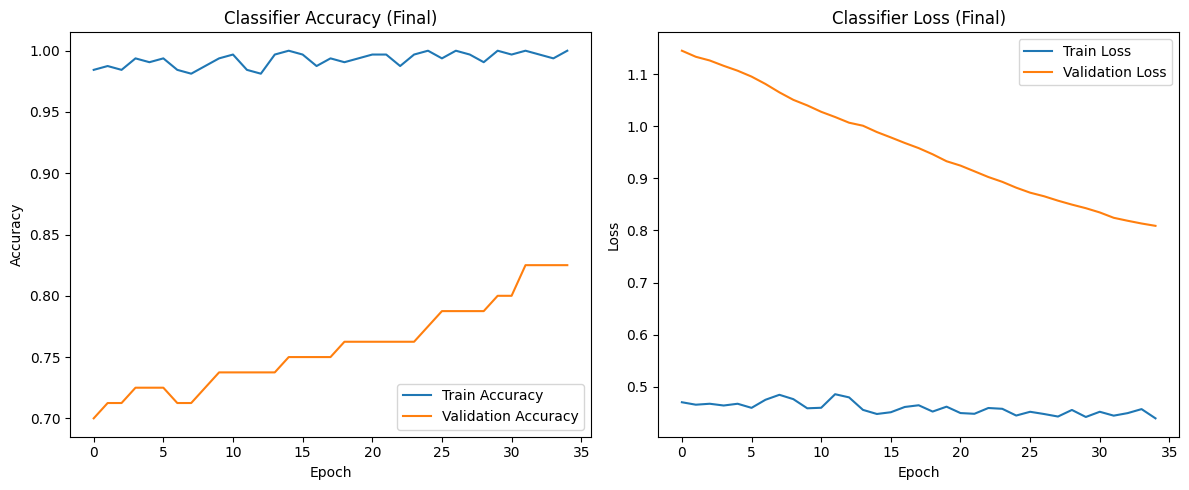

In [97]:
print("\n--- Classification Model Training ---")

callbacks_classification = [
    tf.keras.callbacks.ModelCheckpoint('best_car_classifier.keras',
                                       save_best_only=True,
                                       monitor='val_sparse_categorical_accuracy',
                                       mode='max',
                                       verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=15,
                                     monitor='val_loss',
                                     restore_best_weights=True,
                                     verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=5,
                                         min_lr=1e-7,
                                         verbose=1)
]

history_classification = None

if classification_model and train_ds_classification and val_ds_classification:

    EPOCHS_CLASSIFICATION = 50
    epochs_stage1 = 15

    print(f"\n--- Starting Classification Model Training - Stage 1 (Epochs: {epochs_stage1}) ---")
    print(f"Initial learning rate: {classification_model.optimizer.learning_rate.numpy()}")

    history_stage1 = classification_model.fit(
        train_ds_classification,
        epochs=epochs_stage1,
        validation_data=val_ds_classification,
        callbacks=callbacks_classification
    )

    print(f"\n--- Setting up for Classification Model Training - Stage 2 (Fine-tuning) ---")

    unfreeze_and_lower_lr_for_stage2 = True

    if unfreeze_and_lower_lr_for_stage2 and hasattr(classification_model, 'get_layer'):
        base_model_layer = classification_model.layers[0]

        if hasattr(base_model_layer, 'trainable') and not base_model_layer.trainable:
            print(f"Unfreezing base model: {base_model_layer.name}")
            base_model_layer.trainable = True
        else:
            print(f"Base model: {base_model_layer.name} is already trainable or trainability not changed here.")

        fine_tune_lr = LEARNING_RATE_CLASSIFICATION / 100
        if fine_tune_lr == 0: fine_tune_lr = 1e-6

        print(f"Re-compiling model for fine-tuning with learning rate: {fine_tune_lr}")
        classification_model.compile(
            optimizer=Adam(learning_rate=fine_tune_lr),
            loss=SparseCategoricalCrossentropy(),
            metrics=[SparseCategoricalAccuracy()]
        )

        epochs_stage2 = EPOCHS_CLASSIFICATION - epochs_stage1
        if epochs_stage2 > 0:
            print(f"--- Continuing fine-tuning (Stage 2) for {epochs_stage2} more epochs ---")

            current_epoch_for_stage2 = 0
            if history_stage1 and history_stage1.epoch:
                current_epoch_for_stage2 = history_stage1.epoch[-1] + 1
            else:
                current_epoch_for_stage2 = epochs_stage1


            history_classification = classification_model.fit(
                train_ds_classification,
                epochs=EPOCHS_CLASSIFICATION,
                initial_epoch=current_epoch_for_stage2,
                validation_data=val_ds_classification,
                callbacks=callbacks_classification
            )
        else:
            print("No epochs remaining for Stage 2 fine-tuning.")
            history_classification = history_stage1
    else:
        print("Skipping explicit Stage 2 fine-tuning setup. Training considered completed in Stage 1.")
        history_classification = history_stage1

    print("Car Classification model training potentially finished.")

    if history_classification and hasattr(history_classification, 'history') and history_classification.history:
        print("\nPlotting final training history...")
        plt.figure(figsize=(12, 5))

        if 'sparse_categorical_accuracy' in history_classification.history and \
           'val_sparse_categorical_accuracy' in history_classification.history:
            plt.subplot(1, 2, 1)
            plt.plot(history_classification.history['sparse_categorical_accuracy'], label='Train Accuracy')
            plt.plot(history_classification.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
            plt.title('Classifier Accuracy (Final)')
            plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        if 'loss' in history_classification.history and \
           'val_loss' in history_classification.history:
            plt.subplot(1, 2, 2)
            plt.plot(history_classification.history['loss'], label='Train Loss')
            plt.plot(history_classification.history['val_loss'], label='Validation Loss')
            plt.title('Classifier Loss (Final)')
            plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plotting: Final history_classification object is None or history attribute is missing/empty.")
else:
    print("Skipping classification model training: Model or essential data (train_ds or val_ds) not available.")

In [98]:
print("\n--- Saving Models ---")
if classification_model and history_classification:
    try:
        classification_model.save("final_car_classifier_model.keras")
        print("Final car classification model saved as final_car_classifier_model.keras")
    except Exception as e:
        print(f"Error saving classification model: {e}")
else:
    print("Classification model not available or not trained, skipping save.")

if detection_model:
    try:
        detection_model.save("conceptual_detection_model.keras")
        print("Conceptual detection model saved as conceptual_detection_model.keras")
    except Exception as e:
        print(f"Error saving detection model: {e}")
else:
    print("Detection model not available, skipping save.")


--- Saving Models ---
Final car classification model saved as final_car_classifier_model.keras
Conceptual detection model saved as conceptual_detection_model.keras
